In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import os
import lightgbm as lgb

os.listdir()

['.ipynb_checkpoints',
 'EDA and LightGBM.ipynb',
 'EDA and LSTM.ipynb',
 'registryupload_1.csv',
 'registryupload_2.csv',
 'results_summary.xlsx',
 'test_actual.csv',
 '~$results_summary.xlsx']

In [19]:
df1 = pd.read_csv('registryupload_1.csv')
df2 = pd.read_csv('registryupload_2.csv')

df = df1.append(df2).reset_index()

def extract_date(startdate):
    parts = startdate.split()
    return parts[0]



df["Date"] = pd.to_datetime(df.JobStartDate, format='%m/%d/%Y %H:%M:%S AM', errors = 'coerce', utc=False)
hard_date = datetime.date(1980,1,1)
df['hard_date'] = hard_date
df['hard_date'] = pd.to_datetime(df['hard_date'])
df["days_from"] = df['Date'] - df["hard_date"]
df.days_from = df.days_from.dt.days

print("Full data shape:", df.shape)

Full data shape: (143590, 25)


In [32]:
# Remove rows where no water volume exists
df = df[df['TotalBaseWaterVolume'].notnull()]
df['Latitude'].replace(376223, np.nan, inplace=True)
df = df[df['Latitude'].notnull()]
df = df[df['Longitude'].notnull()]
df = df[df['TVD'].notnull()]
df['OperatorName'] = df['OperatorName'].astype('category')
print("Data shape:", df.shape)
print(df.dtypes)
df.head(10)


Data shape: (113420, 25)
index                               int64
pKey                               object
JobStartDate                       object
JobEndDate                         object
APINumber                           int64
StateNumber                         int64
CountyNumber                        int64
OperatorName                     category
WellName                           object
Latitude                          float64
Longitude                         float64
Projection                         object
TVD                               float64
TotalBaseWaterVolume              float64
TotalBaseNonWaterVolume           float64
StateName                          object
CountyName                         object
FFVersion                           int64
FederalWell                          bool
IndianWell                           bool
Source                            float64
DTMOD                             float64
Date                       datetime64[ns]
hard_date

,index,pKey,JobStartDate,JobEndDate,APINumber,StateNumber,CountyNumber,OperatorName,WellName,Latitude,...,StateName,CountyName,FFVersion,FederalWell,IndianWell,Source,DTMOD,Date,hard_date,days_from
5,5,05e11984-99f4-4727-aebd-15f20e621316,11/19/2008 12:00:00 AM,11/19/2008 12:00:00 AM,37105214840000,37,105,Pennsylvania General Energy,Fisk Hollow PV PAD A #2146,41.847809,...,Pennsylvania,Potter,1,False,False,NaN,NaN,2008-11-19 12:00:00,1980-01-01,10550.0
14,14,7ecb3f11-f69c-4957-9ee9-7ac5c9eadd05,6/29/2009 12:00:00 AM,6/29/2009 12:00:00 AM,37105215000000,37,105,Pennsylvania General Energy,Reed Run Keating PAD A #2145,41.728259,...,Pennsylvania,Potter,1,False,False,NaN,NaN,2009-06-29 12:00:00,1980-01-01,10772.0
15,15,41fa065f-1d8d-4e86-a21d-ce6d5fe89e77,7/7/2009 12:00:00 AM,7/7/2009 12:00:00 AM,37105212980000,37,105,Pennsylvania General Energy,Pine Hill #1941A,41.614847,...,Pennsylvania,Potter,1,False,False,NaN,NaN,2009-07-07 12:00:00,1980-01-01,10780.0
16,16,f98e67c5-8b7b-45b9-84d4-b4e5f2de6e86,7/13/2009 12:00:00 AM,7/13/2009 12:00:00 AM,37059251250000,37,59,Energy Corporation of America,Henderson King #2MH,39.883933,...,PA,Greene,1,False,False,NaN,NaN,2009-07-13 12:00:00,1980-01-01,10786.0
18,18,6246ef12-8aca-47dc-9271-b93a21b9cd1c,8/3/2009 12:00:00 AM,8/3/2009 12:00:00 AM,37053290190000,37,53,Pennsylvania General Energy,Forest #2124,41.550398,...,Pennsylvania,Forest,1,False,False,NaN,NaN,2009-08-03 12:00:00,1980-01-01,10807.0
20,20,17e3ac48-824d-4b3b-b36c-d6ed0170675a,8/17/2009 12:00:00 AM,8/17/2009 12:00:00 AM,37059251390000,37,59,Energy Corporation of America,Blaker Minor #1MH,39.864050,...,PA,Greene,1,False,False,NaN,NaN,2009-08-17 12:00:00,1980-01-01,10821.0
22,22,8158da12-2677-4fda-a808-a8c31bd6a366,9/2/2009 12:00:00 AM,9/2/2009 12:00:00 AM,37105215880000,37,105,Pennsylvania General Energy,Fisk Hollow PV PAD A #2378,41.846893,...,Pennsylvania,Potter,1,False,False,NaN,NaN,2009-09-02 12:00:00,1980-01-01,10837.0
23,23,449beeea-10f4-4d1d-bd63-ba83f4b66e53,9/8/2009 12:00:00 AM,9/8/2009 12:00:00 AM,37059252090000,37,59,Energy Corporation of America,Kemsod #1 MH,39.834189,...,PA,Greene,1,False,False,NaN,NaN,2009-09-08 12:00:00,1980-01-01,10843.0
24,24,88368e57-f1b7-443c-a6a0-66f222d5173c,10/16/2009 12:00:00 AM,10/16/2009 12:00:00 AM,37059251340000,37,59,Energy Corporation of America,HOGE / NOCE # 1 MH,39.882947,...,PA,Greene,1,False,False,NaN,NaN,2009-10-16 12:00:00,1980-01-01,10881.0
26,26,5fa74403-3548-4af2-8757-f01f1abf682d,12/1/2009 12:00:00 AM,12/1/2009 12:00:00 AM,37105214840000,37,105,Pennsylvania General Energy,Pine Hill #2382,41.591955,...,Pennsylvania,Potter,1,False,False,NaN,NaN,2009-12-01 12:00:00,1980-01-01,10927.0


In [44]:
feature_cols = ['Latitude', 'Longitude', 'TVD', 'days_from']
features = df[feature_cols]
labels = df['TotalBaseWaterVolume']

print('Features data frame shape:', features.shape)
print('Labels data frame shape:', labels.shape)

from sklearn.model_selection import train_test_split
# Take out 1% of data for testing

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.01, random_state=42)

# Reset indices
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

print('Training features shape:', X_train.shape)
print('Test features shape:', X_test.shape)




Features data frame shape: (113420, 4)
Labels data frame shape: (113420,)
Training features shape: (112285, 4)
Test features shape: (1135, 4)


In [47]:
from sklearn.model_selection import KFold, StratifiedKFold

def kfold_lightgbm(features, labels, num_folds = 5, stratified=False, debug=False):
    feature_names = features.columns
    
    if stratified: 
        fold = StratifiedKFold(n_splits = num_folds, shuffle=True, random_state = 50)
    else:
        fold = KFold(n_splits = num_folds, shuffle=True, random_state = 50)
        
    feature_importances = np.zeros(len(feature_names))
    
    train_scores=[]
    valid_scores=[]
    
    fold_predictions = np.zeros(features.shape[0])   
    sub_predictions = np.zeros(X_test.shape[0])
    
    features_np = np.array(features)
    
    # Iterate through each fold
    for train_indices, valid_indices in fold.split(features, labels):
        
        # Training data for the fold
        train_features, train_labels = features_np[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features_np[valid_indices], labels[valid_indices]
        
#         params = {
#             'objective': 'regression',
#             'metric' : 'rmse',
#             'max_depth': 5,
#             'learning_rate': 0.1,
#             'verbose': 10,
#             'early_stopping_round': 100
#         }
        n_estimators = 10000
        
        d_train = lgb.Dataset(train_features, label=train_labels, categorical_feature=['OperatorName'])
        d_valid = lgb.Dataset(valid_features, label=valid_labels, categorical_feature=['OperatorName'])
                
        evals_result = {}
       
        model = lgb.LGBMRegressor(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.05,
            num_leaves=25,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        
        model.fit(train_features, train_labels, eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], early_stopping_rounds = 100, verbose = 200, categorical_feature='auto')
        
        best_iteration = model.best_iteration_
        
        feature_importances += model.feature_importances_ / fold.n_splits
        
        fold_predictions[valid_indices] += model.predict(valid_features, num_iteration = best_iteration)
        sub_predictions += model.predict(X_test, num_iteration = best_iteration) / fold.n_splits
        
    return model, sub_predictions, evals_result, feature_importances
    
    
model, sub_predictions, evals_result, feature_importances = kfold_lightgbm(X_train, y_train)
    
        
        

Training until validation scores don't improve for 100 rounds.
[200]	valid's l2: 2.33964e+13	train's l2: 1.64654e+13
[400]	valid's l2: 2.23525e+13	train's l2: 1.4933e+13
[600]	valid's l2: 2.18442e+13	train's l2: 1.39854e+13
[800]	valid's l2: 2.15006e+13	train's l2: 1.32786e+13
[1000]	valid's l2: 2.13184e+13	train's l2: 1.27804e+13
[1200]	valid's l2: 2.11076e+13	train's l2: 1.22899e+13
[1400]	valid's l2: 2.10097e+13	train's l2: 1.19005e+13
[1600]	valid's l2: 2.09165e+13	train's l2: 1.15687e+13
[1800]	valid's l2: 2.08784e+13	train's l2: 1.11947e+13
[2000]	valid's l2: 2.08556e+13	train's l2: 1.0872e+13
[2200]	valid's l2: 2.08333e+13	train's l2: 1.05086e+13
Early stopping, best iteration is:
[2190]	valid's l2: 2.08224e+13	train's l2: 1.05329e+13
Training until validation scores don't improve for 100 rounds.
[200]	valid's l2: 1.17785e+13	train's l2: 1.92183e+13
[400]	valid's l2: 1.0816e+13	train's l2: 1.74571e+13
[600]	valid's l2: 1.02758e+13	train's l2: 1.64148e+13
[800]	valid's l2: 9.9910

# Feature Importance Plot

<BarContainer object of 4 artists>

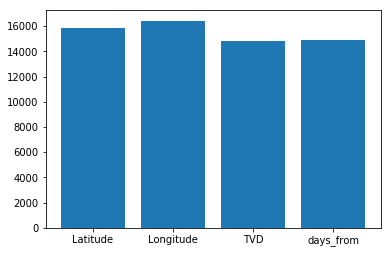

In [25]:
y = feature_importances
x = features.columns

plt.bar(x, y)

Test set RMSE: 2737447.523419618
<class 'pandas.core.series.Series'>
     prediction      actual           mse
0  1.036311e+07  14203266.0  1.474681e+13
1  1.448640e+07  22124213.0  5.833614e+13
2  7.314984e+06   6933809.0  1.452944e+11
3  6.224772e+06   8414511.0  4.794956e+12
4  2.146424e+06   1751085.0  1.562933e+11


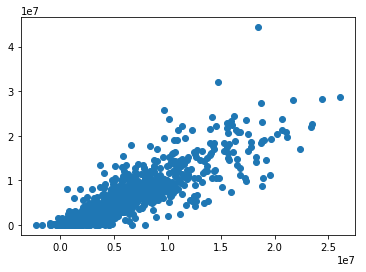

In [46]:
import math

submission_df = pd.DataFrame(sub_predictions)
submission_df.columns = ['prediction']
submission_df['actual'] = y_test
submission_df['mse'] = (submission_df.actual - submission_df.prediction) ** 2

print("Test set RMSE:", math.sqrt(submission_df.mse.mean()))

x = submission_df['prediction']
y = submission_df['actual']

print(type(y))

plt.scatter(x,y)

print(submission_df.head())

submission_df.to_csv('lightgbm_results.csv', index=False)